In [186]:
from __future__ import annotations

from typing import List, Tuple
from optyx.core.diagram import Box, Diagram, Spider, Swap
from optyx.core import zw

LO_ELEMENTS = (
    zw.Create,
    zw.W,
    zw.Select,
    zw.Add,
    zw.Endo
)

def update_connections(
    wires_in_light_cone: List[bool],
    previous_left_offset: int,
    previous_box: Box,
    previous_right_offset: int,
) -> List[bool]:
    """
    Replace the previous box's COD segment in the light-cone by a DOM-length
    segment that is either all True (if connected) or all False.
    This pulls the cone one layer backward.
    """
    connected = is_previous_box_connected_to_current_box(
        wires_in_light_cone,
        previous_left_offset,
        len(previous_box.cod),
        previous_right_offset,
    )

    start = previous_left_offset
    end = len(wires_in_light_cone) - previous_right_offset

    # replace cod slice with a dom-length slice of the same boolean
    return (
        wires_in_light_cone[:start]
        + [connected] * len(previous_box.dom)
        + wires_in_light_cone[end:]
    )

def calculate_right_offset(total_wires: int, left_offset: int, span_len: int) -> int:
    """Right offset = number of wires to the right of a span."""
    return total_wires - span_len - left_offset

def is_previous_box_connected_to_current_box(
    wires_in_light_cone: List[bool],
    previous_left_offset: int,
    previous_box_cod_len: int,
    previous_right_offset: int,
) -> bool:
    """
    Do the current light-cone wires intersect the COD of the previous box?
    """
    mask = (
        [False] * previous_left_offset
        + [True] * previous_box_cod_len
        + [False] * previous_right_offset
    )
    # lengths should match by construction
    assert len(mask) == len(wires_in_light_cone), (
        f"Mask/wires length mismatch: {len(mask)} != {len(wires_in_light_cone)}"
    )

    return any(w and m for w, m in zip(wires_in_light_cone, mask))

def get_previous_box_cod_index_in_light_cone(
    wires_in_light_cone: List[bool],
    previous_left_offset: int,
    previous_box_cod_len: int,
    previous_right_offset: int,
) -> List[int]:
    """
    Get the indices of the COD of the previous box that are in the current light-cone.
    """
    mask = (
        [False] * previous_left_offset
        + [True] * previous_box_cod_len
        + [False] * previous_right_offset
    )
    # lengths should match by construction
    assert len(mask) == len(wires_in_light_cone), (
        f"Mask/wires length mismatch: {len(mask)} != {len(wires_in_light_cone)}"
    )

    return [
        i - previous_left_offset for i, (w, m) in enumerate(zip(wires_in_light_cone, mask))
        if w and m
    ]


def get_max_dim_for_box(
    left_offset: int,
    box: Box,
    right_offset: int,
    input_dims: List[int],
    prev_layers: List[Tuple[int, Box]],
):

    if len(box.dom) == 0 or isinstance(box, Swap):
        return 1e20

    dim_for_box = 0

    # light-cone at the current layer inputs
    wires_in_light_cone: List[bool] = (
        [False] * left_offset
        + [True] * len(box.dom)
        + [False] * right_offset
    )

    for previous_left_offset, previous_box in prev_layers[::-1]:
        previous_right_offset = calculate_right_offset(
            len(wires_in_light_cone), previous_left_offset, len(previous_box.cod)
        )

        if is_previous_box_connected_to_current_box(
            wires_in_light_cone,
            previous_left_offset,
            len(previous_box.cod),
            previous_right_offset,
        ):

            if isinstance(previous_box, zw.Create):
                idxs = get_previous_box_cod_index_in_light_cone(
                    wires_in_light_cone,
                    previous_left_offset,
                    len(previous_box.cod),
                    previous_right_offset,
                )
                dim_for_box += sum(previous_box.photons[i] for i in idxs)

        wires_in_light_cone = update_connections(
            wires_in_light_cone,
            previous_left_offset,
            previous_box,
            previous_right_offset,
        )

    dim_for_box += sum(2*dim for wire, dim in zip(wires_in_light_cone, input_dims) if wire) + 1
    return dim_for_box


In [147]:
from optyx.photonic import ansatz, Create
import numpy as np
from optyx import qmode

def chip_mzi(w, l):
    ansatz_ = ansatz(w, l)
    symbs = list(ansatz_.free_symbols)
    s = [(i, np.random.uniform(0, 1)) for i in symbs]
    return ansatz_.subs(*s)


In [ ]:
from optyx.core import zw
from optyx import Channel

def _number_operator():
    return (
        zw.W(2) >>
        zw.Select(1) @ zw.Id(1) >>
        zw.Create(1) @ zw.Id(1) >>
        zw.W(2).dagger()
    )

def _monomial_number_operator(power):
    diag = zw.Id(1)
    for i in range(power):
        diag = diag >> _number_operator()
    return diag

def _get_monomial_layer(powers):
    monomial_layer = zw.Id(0)
    for power in powers:
        monomial_layer = monomial_layer @ _monomial_number_operator(power)

    return Channel("l", monomial_layer)

In [190]:
from discopy import tensor
from optyx.core.diagram import Dim, modify_io_dims_against_max_dim

# pylint: disable=too-many-locals
def to_tensor(
    self, input_dims: list = None
) -> tensor.Diagram:
    """Returns a :class:`tensor.Diagram` for evaluation"""
    from optyx.core import zw

    prev_layers: List[Tuple[int, Box]] = []

    # pylint: disable=import-outside-toplevel
    def list_to_dim(dims: np.ndarray | list) -> Dim:
        """Converts a list of dimensions to a Dim object"""
        return Dim(*[int(i) for i in dims])

    number_of_input_layer_wires = len(self.dom)

    if input_dims is None:
        layer_dims = [2 for _ in range(len(self.dom))]
    else:
        assert len(self.dom) == len(input_dims), (
            f"Input dims length {len(input_dims)} does not match number of input wires {len(self.dom)}"
        )
        layer_dims = input_dims

    if len(self.boxes) == 0 and len(self.offsets) == 0:
        return tensor.Diagram.id(list_to_dim(layer_dims))

    for i, (box, left_offset) in enumerate(zip(self.boxes, self.offsets)):
        right_offset = calculate_right_offset(
            number_of_input_layer_wires, left_offset, len(box.dom)
        )

        max_dim = get_max_dim_for_box(
            left_offset,
            box,
            right_offset,
            layer_dims,
            prev_layers
        )

        dims_in = layer_dims[left_offset:left_offset + len(box.dom)]
        dims_out, _ = modify_io_dims_against_max_dim(
            box.determine_output_dimensions(dims_in),
            None,
            max_dim
            )
        if isinstance(box, LO_ELEMENTS):
            prev_layers.append((left_offset, box))
        else:
            prev_layers.append(
                (left_offset, zw.Select(*dims_in) >> zw.Create(*dims_out))
            )

        left = Dim()
        if left_offset > 0:
            left = list_to_dim(layer_dims[0:left_offset])
        right = Dim()
        if left_offset + len(box.dom) < number_of_input_layer_wires:
            right = list_to_dim(
                layer_dims[left_offset + len(box.dom): number_of_input_layer_wires]
            )

        number_of_input_layer_wires += -len(box.dom) + len(box.cod)
        cod_layer_dims = (
            layer_dims[0:left_offset]
            + dims_out
            + layer_dims[left_offset + len(box.dom):]
        )

        diagram_ = left @ box.truncation(dims_in, dims_out) @ right
        if i == 0:
            diagram = diagram_
        else:
            diagram = diagram >> diagram_

        layer_dims = cod_layer_dims

    zboxes = tensor.Id(Dim(1))

    # pylint: disable=invalid-name
    for c in diagram.cod:
        zboxes @= zw.ZBox(1, 1, lambda i: 1).truncation(
            input_dims=[int(c.inside[0])], output_dims=[int(c.inside[0])]
        )
    diagram >>= zboxes
    return diagram


In [160]:
d = _get_monomial_layer([2, 0, 1, 3]).get_kraus()

In [161]:
#d.to_tensor().foliation().draw()

In [162]:
#to_tensor(d).foliation().draw()

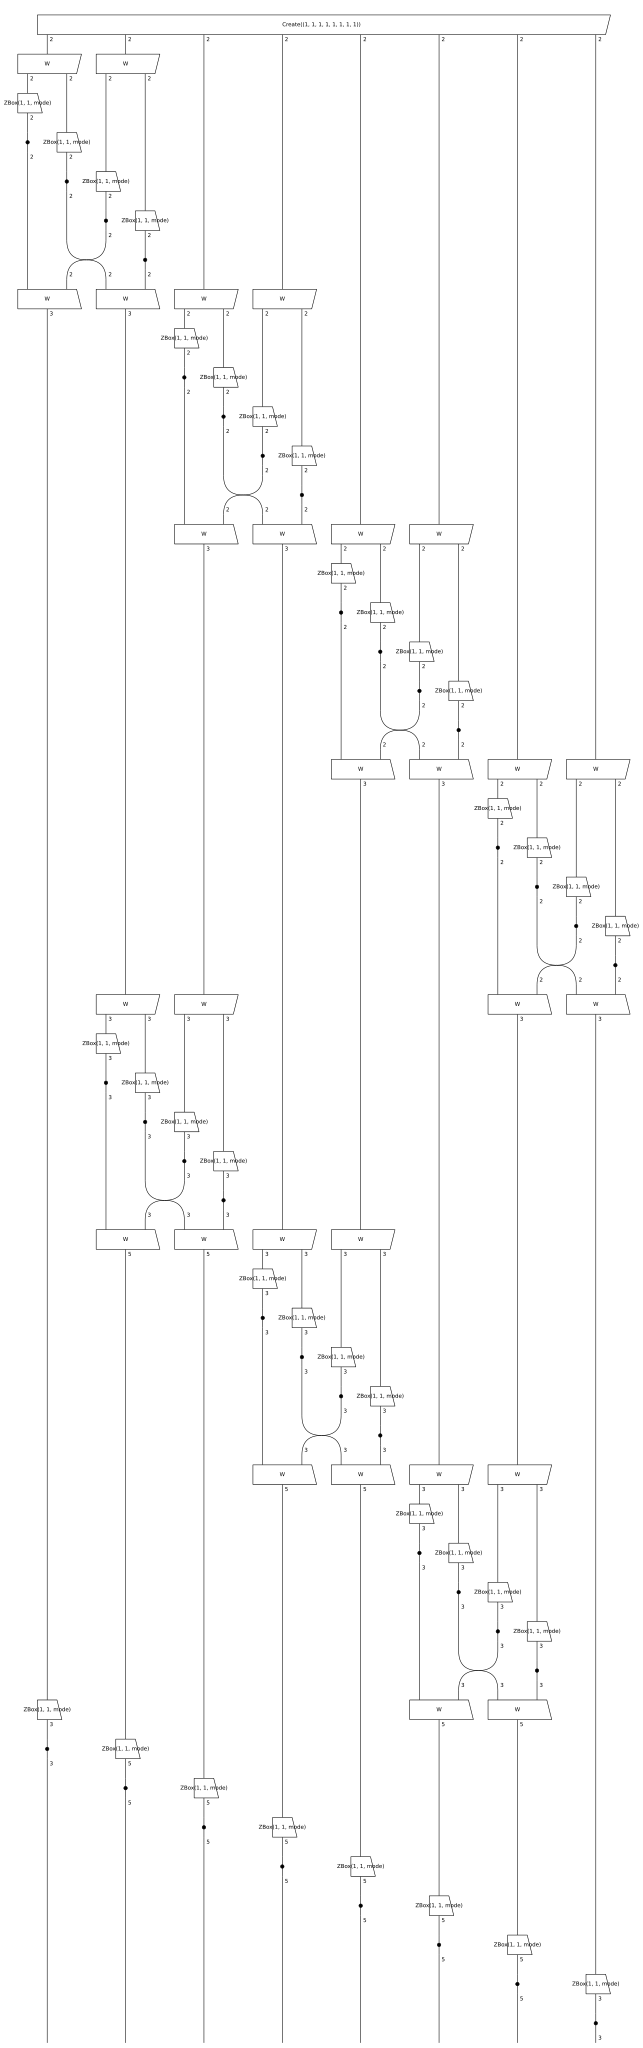

In [154]:
chip = chip_mzi(8, 2)
(Create(*[1]*8) >> chip).get_kraus().to_tensor().foliation().draw()

Create((1, 1, 1, 1, 1, 1, 1, 1))
W
W
Endo((-0.3234307046382588+0.11332561404425955j))
Endo((0.32195587565695744+0.8825498844986909j))
Endo((0.8865927060326879-0.3106497354068188j))
Endo((0.11745011550130909+0.32195587565695744j))
Swap(mode, mode)
W[::-1]
W[::-1]
W
W
Endo((0.4169034852779769+0.5488356489283379j))
Endo((-0.4993760641366437+0.5249709144284862j))
Endo((0.43827131417118825+0.5769654838923606j))
Endo((0.4750290855715139-0.4993760641366437j))
Swap(mode, mode)
W[::-1]
W[::-1]
W
W
Endo((-0.30134644704603486+0.04581902450731501j))
Endo((0.29030496026090463+0.9070909358459293j))
Endo((0.9415913197596348-0.1431667642968796j))
Endo((0.09290906415407064+0.29030496026090463j))
Swap(mode, mode)
W[::-1]
W[::-1]
W
W
Endo((0.024661152392129276-0.6329378798550435j))
Endo((-0.4901451026153749+0.5987814678072949j))
Endo((0.03012708063058259-0.773223012345063j))
Endo((0.4012185321927052-0.4901451026153749j))
Swap(mode, mode)
W[::-1]
W[::-1]
W
W
Endo((-0.928115312565149-0.2467101549282078j))


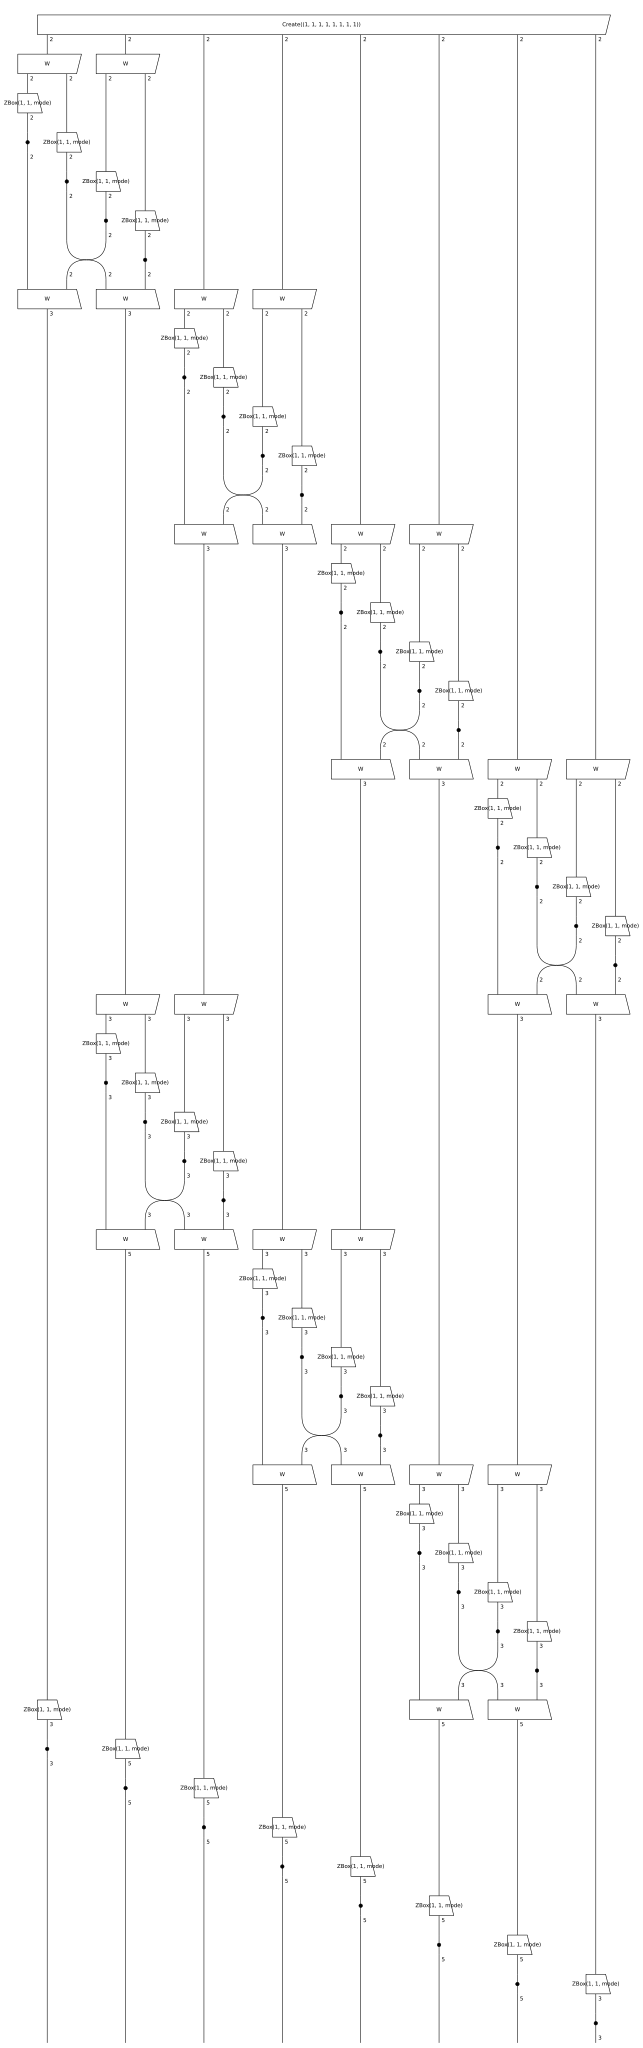

In [188]:
to_tensor((Create(*[1]*8) >> chip).get_kraus()).foliation().draw()

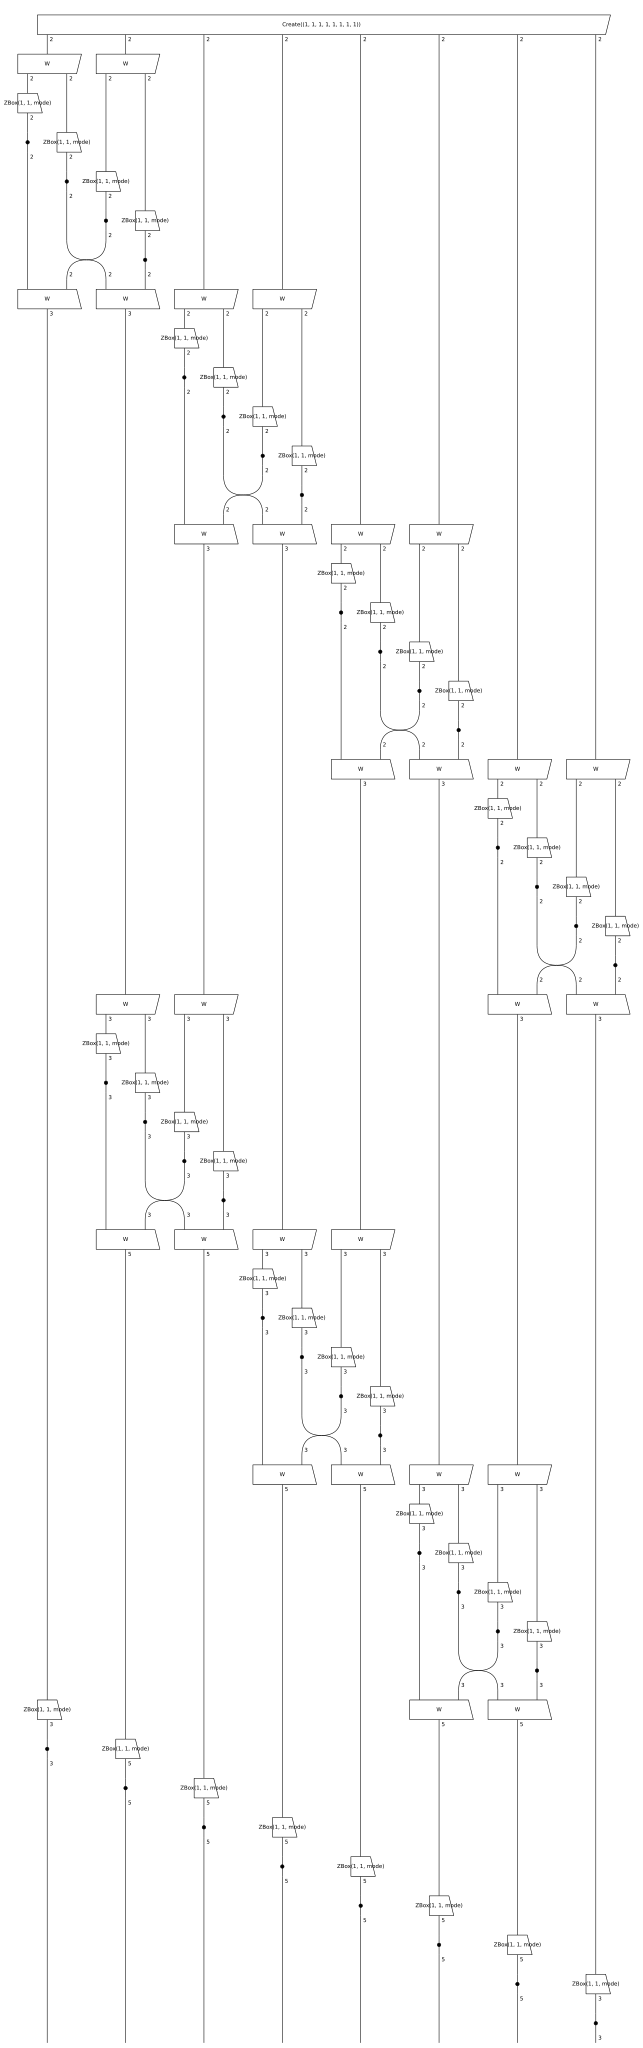

In [191]:
to_tensor((Create(*[1]*8) >> chip).get_kraus()).foliation().draw()

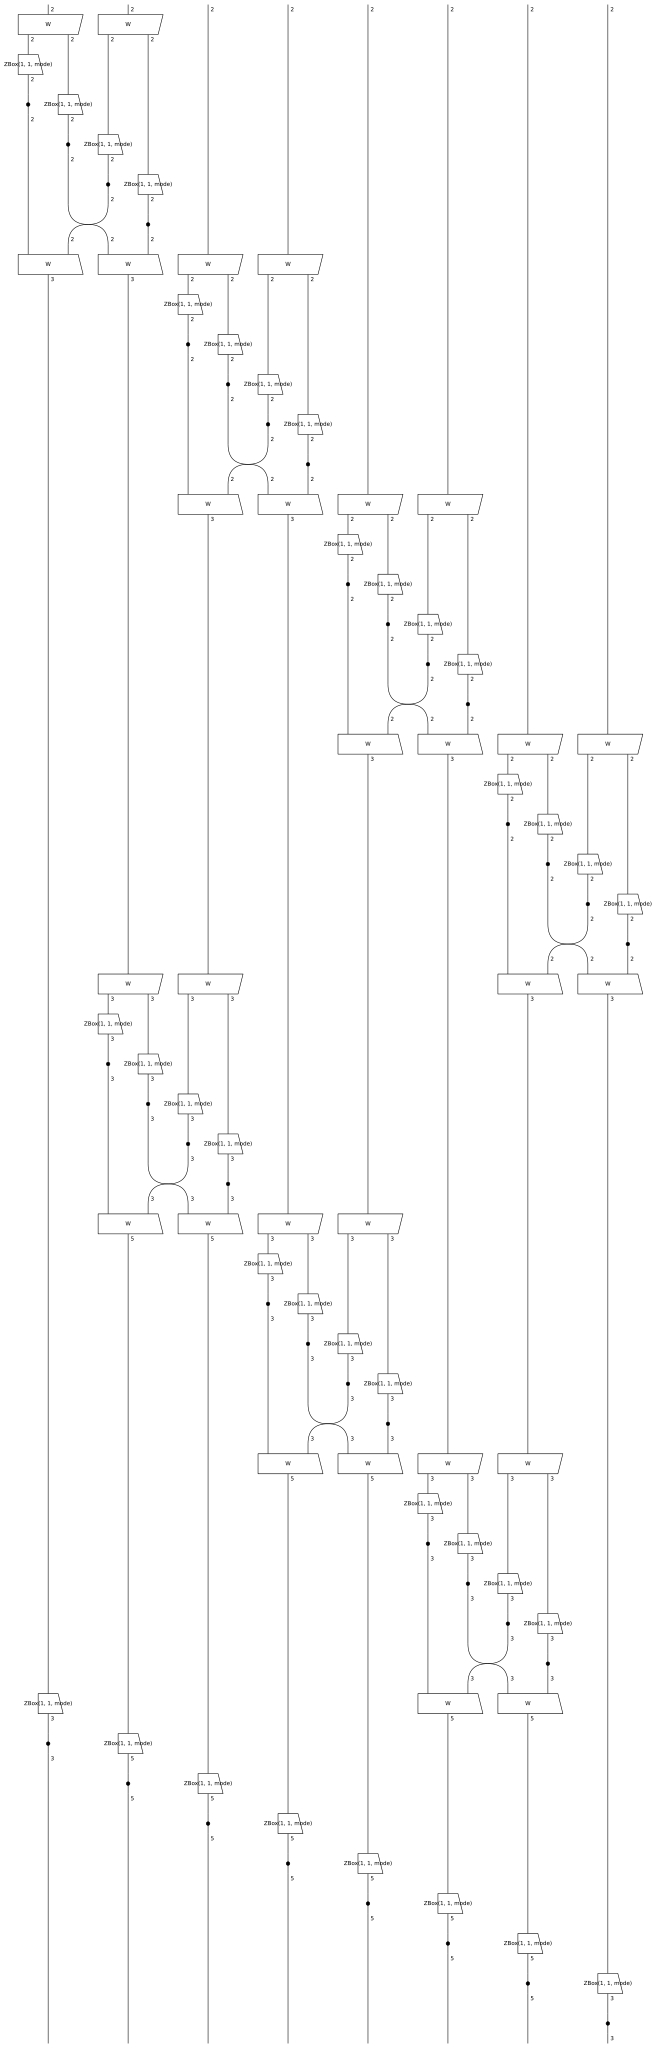

In [192]:
to_tensor((chip).get_kraus()).foliation().draw()

In [ ]:
# IF THE DIAGRAM IS ONLY COMPOSED OF LO BOXES
def dims_for_lo_boxes(diagram: Diagram, input_dims: List[int]) -> List[Tuple[Box, int]]:
    prev_layers: List[Tuple[int, Box]] = []
    dims_for_boxes: List[Tuple[Box, int]] = []


    assert len(diagram.dom) == len(input_dims), (
        f"Input dims length {len(input_dims)} does not match number of input wires {len(diagram.dom)}"
    )
    number_of_input_layer_wires = len(diagram.dom)

    #post_selections = get_postselections(diagram)

    for box, left_offset in zip(
        diagram.boxes,
        diagram.offsets,
        #post_selections
    ):
        right_offset = calculate_right_offset(
            number_of_input_layer_wires, left_offset, len(box.dom)
        )

        # light-cone at the current layer inputs
        wires_in_light_cone: List[bool] = (
            [False] * left_offset
            + [True] * len(box.dom)
            + [False] * right_offset
        )

        dim_for_box = 0

        # walk backwards through previous layers
        #used_ps = []

        for previous_left_offset, previous_box in prev_layers[::-1]:
            previous_right_offset = calculate_right_offset(
                len(wires_in_light_cone), previous_left_offset, len(previous_box.cod)
            )

            if is_previous_box_connected_to_current_box(
                wires_in_light_cone,
                previous_left_offset,
                len(previous_box.cod),
                previous_right_offset,
            ):

                if isinstance(previous_box, zw.Create):
                    idxs = get_previous_box_cod_index_in_light_cone(
                        wires_in_light_cone,
                        previous_left_offset,
                        len(previous_box.cod),
                        previous_right_offset,
                    )
                    dim_for_box += sum(previous_box.photons[i] for i in idxs)

            # for p in ps:
            #     if p[0] not in used_ps:
            #         dim_for_box -= p[1]
            #         used_ps.append(p[0])

            wires_in_light_cone = update_connections(
                wires_in_light_cone,
                previous_left_offset,
                previous_box,
                previous_right_offset,
            )

        dim_for_box += sum(1*dim for wire, dim in zip(wires_in_light_cone, input_dims) if wire)

        dims_for_boxes.append((box, dim_for_box + 1))
        if isinstance(box, LO_ELEMENTS):
            prev_layers.append((left_offset, box))
        else:
            pass

        number_of_input_layer_wires += -len(box.dom) + len(box.cod)

    return dims_for_boxes

In [ ]:
# IF THE DIAGRAM IS ONLY COMPOSED OF LO BOXES
def get_postselections(diagram: Diagram) -> List[Tuple[Box, int]]:
    diagram = diagram.dagger()
    prev_layers: List[Tuple[int, Box]] = []
    postselection_for_boxes: List[Tuple[Box, int]] = []

    number_of_input_layer_wires = len(diagram.dom)

    for box, left_offset in zip(diagram.boxes, diagram.offsets):
        right_offset = calculate_right_offset(
            number_of_input_layer_wires, left_offset, len(box.dom)
        )

        # light-cone at the current layer inputs
        wires_in_light_cone: List[bool] = (
            [False] * left_offset
            + [True] * len(box.dom)
            + [False] * right_offset
        )

        postselections_for_box = []

        # walk backwards through previous layers
        for previous_left_offset, previous_box in prev_layers[::-1]:
            previous_right_offset = calculate_right_offset(
                len(wires_in_light_cone), previous_left_offset, len(previous_box.cod)
            )

            if is_previous_box_connected_to_current_box(
                wires_in_light_cone,
                previous_left_offset,
                len(previous_box.cod),
                previous_right_offset,
            ):

                if isinstance(previous_box, zw.Create):
                    idxs = get_previous_box_cod_index_in_light_cone(
                        wires_in_light_cone,
                        previous_left_offset,
                        len(previous_box.cod),
                        previous_right_offset,
                    )
                    postselections_for_box.append(
                        (id(previous_box), sum(previous_box.photons[i] for i in idxs))
                    )

            wires_in_light_cone = update_connections(
                wires_in_light_cone,
                previous_left_offset,
                previous_box,
                previous_right_offset,
            )

        postselection_for_boxes.append((postselections_for_box))
        if isinstance(box, LO_ELEMENTS):
            prev_layers.append((left_offset, box))
        else:
            pass

        number_of_input_layer_wires += -len(box.dom) + len(box.cod)

    return postselection_for_boxes[::-1]